In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
from scipy.stats import hypergeom,ks_2samp
from matplotlib import rcParams
from collections import defaultdict
from pyCRAC.Methods import sortbyvalue,contigousarray2Intervals
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['axes.formatter.useoffset'] = False


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def formatAxes(ax,text_size=10,xlim=None,xlabel=None,xticks=None,xticklabels=None,ylim=None,yticks=None,ylabel=None,yticklabels=None):
    """ to tweak the plotting of the axes as well as the fontsize """
    for loc,spine in list(ax.spines.items()):
        if loc == 'left': # settings for the y-axis
            if yticklabels and not yticks:
                sys.stderr.write("Need to provide a list wiht both y-labels and y-ticks!")
            if yticks:
                ax.yaxis.set_ticks_position('left')
                ax.yaxis.set_tick_params(direction='out')
                spine.set_visible(True)
                spine.set_position(("outward",1))
                spine.set_smart_bounds(True)
                ax.set_yticks(yticks)
                if ylim:
                    ax.set_ylim(ylim)
                if yticklabels:
                    ax.set_yticklabels(yticklabels,fontsize=text_size)
            else:
                spine.set_visible(False)
                ax.set_yticklabels([])
                ax.tick_params(axis='y',which='both',length=0)
                
            if ylabel:
                ax.set_ylabel(ylabel,fontsize=text_size,rotation=0,labelpad=160)
                ax.get_yaxis().set_label_coords(-0.1,0.5)
        elif loc == 'bottom': # settings for x-axis
            if xticks:
                spine.set_position('zero')
                spine.set_visible(False)
                spine.set_smart_bounds(False)
                ax.set_xticks(xticks)
                ax.tick_params(axis='x',which='both',length=0)
                if xlim:
                    ax.set_xlim(xlim)
                if xticklabels:
                    ax.set_xticklabels(xticklabels,fontsize=text_size)
            else:
                spine.set_visible(False)
                ax.set_xticklabels([])
                ax.tick_params(axis='x',which='both',length=0)
                
            if xlabel:
                ax.tick_params(axis='x',which='both',length=0)
                ax.set_xlabel(xlabel,fontsize=text_size+2)
                ax.xaxis.labelpad = 10
        else:
            spine.set_visible(False)
    ax.patch.set_visible(False)

In [3]:
def binData(data,numberofbins=20):
    """ divides the features in an equal number of bins """
    if len(data) >= numberofbins:
        return np.array([i.sum() for i in np.array_split(data,numberofbins)])
    else:
        return list()

### Loading the big dataframe:

In [4]:
alldata = pd.read_csv('../../../New_data_table.txt',\
                      sep="\t",\
                      header=0,\
                      index_col=0)

In [5]:
alldata.head()

,nucleotide,CELF1,FUS,HuR,PTBP1,RBFOX2,TARDBP,SHAPE_reactivity_ex_vivo_1,SHAPE_reactivity_ex_vivo_2,SHAPE_reactivity_in_cell_1,...,dStruct,dStruct_scaled,unmodified,ex_vivo,in_vivo,both,scaled_unmodified,scaled_ex_vivo,scaled_in_vivo,scaled_both
1,C,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,0,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
2,G,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,0,0,0.712398,0.131639,0.131639,0.024325,0.712398,0.131639,0.131639,0.024325
3,G,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,0,0,0.761379,0.111191,0.111191,0.016238,0.761379,0.111191,0.111191,0.016238
4,C,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,0,0,0.795446,0.096432,0.096432,0.011690,0.795446,0.096432,0.096432,0.011690
5,T,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,0,0,0.819621,0.085708,0.085708,0.008963,0.819621,0.085708,0.085708,0.008963


### Masking positions not considered by deltaSHAPE:

### We need to delete these rows:
first make a list of all the indices that you want to have deleted:

In [6]:
allpositions = list()
starts = [1,2451,2500,17801]
ends = [79,2600,4501,17919]
for start,end in list(zip(starts,ends)):
    allpositions.extend(np.arange(start,end))


In [7]:
allpositions[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Now deleting all the positions:

In [8]:
alldata.drop(allpositions,inplace=True)

In [9]:
alldata.head()

,nucleotide,CELF1,FUS,HuR,PTBP1,RBFOX2,TARDBP,SHAPE_reactivity_ex_vivo_1,SHAPE_reactivity_ex_vivo_2,SHAPE_reactivity_in_cell_1,...,dStruct,dStruct_scaled,unmodified,ex_vivo,in_vivo,both,scaled_unmodified,scaled_ex_vivo,scaled_in_vivo,scaled_both
79,G,0,0,0,0,0,0,0.031491,-0.128846,0.859859,...,0,0,0.953725,2.286328e-02,2.286328e-02,5.480920e-04,0.953725,2.286328e-02,2.286329e-02,5.480930e-04
80,G,0,0,0,0,0,0,-0.304057,-0.455325,-0.453171,...,0,0,0.974195,1.281835e-02,1.281835e-02,1.686630e-04,0.974195,1.281835e-02,1.281836e-02,1.686630e-04
81,G,0,0,0,0,0,0,-0.883056,-0.652497,-0.441984,...,0,0,1.000000,1.490000e-25,9.630000e-19,1.440000e-43,1.000000,6.060000e-21,5.730000e-15,3.470000e-35
82,G,0,0,0,0,0,0,-1.593320,-0.378628,-1.729645,...,0,0,0.994483,2.754800e-03,2.754800e-03,7.630000e-06,0.986340,6.823904e-03,6.789031e-03,4.700000e-05
83,G,0,0,0,0,0,0,-999.000000,-999.000000,-999.000000,...,0,0,1.000000,1.510000e-37,4.420000e-22,6.650000e-59,0.981774,9.110841e-03,9.031603e-03,8.380000e-05


### ROC 

In [10]:
alldata.columns

Index(['nucleotide', 'CELF1', 'FUS', 'HuR', 'PTBP1', 'RBFOX2', 'TARDBP',
       'SHAPE_reactivity_ex_vivo_1', 'SHAPE_reactivity_ex_vivo_2',
       'SHAPE_reactivity_in_cell_1', 'SHAPE_reactivity_in_cell_2',
       'deltaSHAPE_rep1', 'deltaSHAPE_rep2', 'dStruct', 'dStruct_scaled',
       'unmodified', 'ex_vivo', 'in_vivo', 'both', 'scaled_unmodified',
       'scaled_ex_vivo', 'scaled_in_vivo', 'scaled_both'],
      dtype='object')

### Extracting positions that have a binding site:

In [11]:
threshold = 0.95

proteins = ["CELF1","FUS","HuR","PTBP1","RBFOX2","TARDBP"]

allbindingsites = alldata[alldata[proteins].any(axis=1)]

In [12]:
allbindingsites.head()

,nucleotide,CELF1,FUS,HuR,PTBP1,RBFOX2,TARDBP,SHAPE_reactivity_ex_vivo_1,SHAPE_reactivity_ex_vivo_2,SHAPE_reactivity_in_cell_1,...,dStruct,dStruct_scaled,unmodified,ex_vivo,in_vivo,both,scaled_unmodified,scaled_ex_vivo,scaled_in_vivo,scaled_both
154,T,0,0,0,0,1,0,0.747559,0.894118,0.096494,...,0,0,1.000000,8.250000e-12,4.750000e-61,3.920000e-72,1.000000,1.410000e-07,2.430000e-50,3.430000e-57
155,T,0,0,0,0,1,0,0.965702,0.027744,1.696868,...,0,0,1.000000,2.570000e-26,1.310000e-35,3.370000e-61,1.000000,5.170000e-20,1.740000e-28,9.000000e-48
156,T,0,0,0,0,1,0,-0.116280,2.742048,-0.641401,...,0,0,1.000000,2.270000e-34,7.150000e-48,1.620000e-81,1.000000,2.360000e-24,2.240000e-37,5.290000e-61
157,T,0,0,0,0,1,0,1.515716,1.909354,0.594441,...,0,0,0.005100,9.948987e-01,5.660000e-09,1.100000e-06,0.000027,9.998222e-01,4.110000e-09,1.504750e-04
158,G,0,0,0,0,1,0,1.362130,1.634688,1.078887,...,0,0,0.207881,7.921193e-01,2.170000e-12,8.250000e-12,0.000150,9.998495e-01,3.170000e-12,2.110000e-08


### Extracting positions that have no binding site:

In [13]:
nobindingsites = alldata[alldata[proteins].sum(axis=1) == 0]

In [14]:
nobindingsites.head()

,nucleotide,CELF1,FUS,HuR,PTBP1,RBFOX2,TARDBP,SHAPE_reactivity_ex_vivo_1,SHAPE_reactivity_ex_vivo_2,SHAPE_reactivity_in_cell_1,...,dStruct,dStruct_scaled,unmodified,ex_vivo,in_vivo,both,scaled_unmodified,scaled_ex_vivo,scaled_in_vivo,scaled_both
79,G,0,0,0,0,0,0,0.031491,-0.128846,0.859859,...,0,0,0.953725,2.286328e-02,2.286328e-02,5.480920e-04,0.953725,2.286328e-02,2.286329e-02,5.480930e-04
80,G,0,0,0,0,0,0,-0.304057,-0.455325,-0.453171,...,0,0,0.974195,1.281835e-02,1.281835e-02,1.686630e-04,0.974195,1.281835e-02,1.281836e-02,1.686630e-04
81,G,0,0,0,0,0,0,-0.883056,-0.652497,-0.441984,...,0,0,1.000000,1.490000e-25,9.630000e-19,1.440000e-43,1.000000,6.060000e-21,5.730000e-15,3.470000e-35
82,G,0,0,0,0,0,0,-1.593320,-0.378628,-1.729645,...,0,0,0.994483,2.754800e-03,2.754800e-03,7.630000e-06,0.986340,6.823904e-03,6.789031e-03,4.700000e-05
83,G,0,0,0,0,0,0,-999.000000,-999.000000,-999.000000,...,0,0,1.000000,1.510000e-37,4.420000e-22,6.650000e-59,0.981774,9.110841e-03,9.031603e-03,8.380000e-05


### What is the average length of the protein binding site intervals?

In [15]:
for i in proteins:
    print(i)
    lenghts = list()
    positions = alldata[alldata[i] == 1].index
    lengths = [j+1-i for i,j in contigousarray2Intervals(positions)]
    print(np.mean(lengths))
    print(np.std(lengths))

CELF1
38.19047619047619
24.39285423783943
FUS
34.7319587628866
22.681349558893814
HuR
95.75
84.63463140661352
PTBP1
27.454545454545453
10.756508696544754
RBFOX2
22.0
0.0
TARDBP
31.41176470588235
15.518712892085787


### Perhaps dividing the rest into average of 30 bp?

In [16]:
totallength = len(nobindingsites.index)
binlength = 30.0
totalbins = round(totallength/binlength)
significantregions = nobindingsites[nobindingsites["scaled_ex_vivo"] >= threshold]
diffbumhmmnobind = binData(significantregions["scaled_ex_vivo"],numberofbins=totalbins)

In [17]:
totallength = len(allbindingsites.index)
binlength = 30.0
totalbins = round(totallength/binlength)
significantregions = allbindingsites[allbindingsites["scaled_ex_vivo"] >= threshold]
diffbumhmmbind = binData(significantregions["scaled_ex_vivo"],numberofbins=totalbins)

In [18]:
diffbumhmmnobind

array([3.97437967, 3.93895069, 3.93552401, 3.97583443, 3.94953148,
       3.961846  , 3.99742533, 3.96590197, 3.99959257, 3.99943654,
       3.97667363, 3.99370169, 3.98771731, 3.98361319, 3.99917967,
       3.97801132, 3.99274274, 3.95333747, 3.9989458 , 3.99172605,
       3.98586327, 3.98700749, 3.99146199, 3.99964779, 3.9956887 ,
       3.99741263, 3.95147501, 3.99839073, 3.99386936, 3.99993256,
       3.98721654, 3.95255404, 3.99780031, 3.95577798, 3.96027375,
       3.97706965, 3.97324275, 3.98150271, 3.99174154, 3.99965252,
       3.99210725, 3.99675454, 3.99441241, 3.94359564, 3.99755643,
       3.98734153, 3.99602023, 3.96853798, 3.97432598, 3.99292998,
       3.99686787, 3.94137096, 3.98259631, 3.98666925, 3.99835768,
       3.9502446 , 3.96092517, 3.99724456, 3.99826615, 3.98206351,
       3.95458507, 3.94867398, 3.99914065, 3.93283866, 3.97079606,
       3.98846036, 3.98846355, 3.97763338, 3.96492407, 3.9541907 ,
       3.99936918, 3.97594043, 3.99197108, 3.96840041, 3.99380

In [19]:
diffbumhmmbind

array([3.90886684, 3.94737161, 3.99683463, 3.88373864, 3.95082545,
       3.97770473, 3.99625055, 3.93292366, 3.98503032, 3.99720538,
       3.98087237, 3.97219217, 3.96873615, 3.99914811, 3.99800172,
       3.93273704, 3.99683488, 3.97838103, 3.94864734, 3.94611347,
       3.9634505 , 3.99082345, 3.99896379, 3.98064509, 3.98915284,
       3.97957943, 3.9337888 , 3.96613509, 3.99127947, 3.96975446,
       3.99808161, 3.99775359, 3.97491128, 3.95947926, 3.99224005,
       3.99036604, 3.93450245, 3.9524644 , 3.99708826, 3.97553522,
       3.98887388, 3.97325375, 3.99518869, 3.97754272, 3.99027255,
       3.99351409, 3.96878367, 3.97843207, 3.94965626, 3.9932357 ,
       3.98807689, 3.91449573, 3.98730378, 3.99021636, 2.99992637,
       2.98796229, 2.99963888, 2.99401913, 2.99988461, 2.98853309,
       2.97878183, 2.95477117, 2.99980456, 2.93714135, 2.99916101,
       2.99275196, 2.99965001, 2.99040418, 2.96909037, 2.99837013,
       2.9999491 , 2.99352287, 2.96812533, 2.99021399, 2.99690

{'bodies': [<matplotlib.collections.PolyCollection at 0x1058d85f8>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a1988a780>,
 'cmins': <matplotlib.collections.LineCollection at 0x1058d8828>,
 'cbars': <matplotlib.collections.LineCollection at 0x1058e0550>}

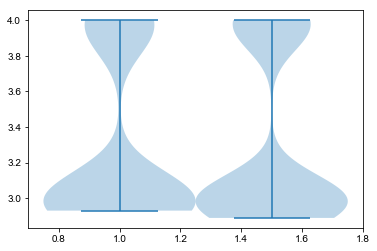

In [20]:
fig,ax = plt.subplots()
ax.violinplot([diffbumhmmbind,diffbumhmmnobind],positions=[1,1.5])
#ax.set_yticks(np.arange(1,5))

### Are they statistically significantly different?

In [21]:
ks_2samp(diffbumhmmbind,diffbumhmmnobind)

Ks_2sampResult(statistic=0.0613285350127456, pvalue=0.7674443342325517)

### Answer is not even close.

In [22]:
#SETTING NUCLEOTIDES TO ZERO IF FALLING IN REGIONS NOT USED BY DIFFBUM HMM
proteins = ["CELF1","FUS","HuR","PTBP1","RBFOX2","TARDBP"]


#for index, row in alldata.iterrows():
#    if index>=1 and index<=78 or index>=2451 and index<=2599 or index>=2500 and index<=4500 or index>=17801 and index<=17918:
#        for protein in proteins:
#            row[protein]=0

### This can be done more efficient: see below.
### This isn't the correct way to do it as you will add more false negatives.
### You have to remove the rows from the dataframe!

In [23]:
### The nice thing about pandas is that you don't have to do for loops to iterate over each row.
### Shorter and faster:

alldata.loc[1:78,proteins] = 0
alldata.loc[2451:2599,proteins] = 0
alldata.loc[2500:4500,proteins] = 0
alldata.loc[17801:17918,proteins] = 0

In [25]:
#FOR ROC we need to plot true positive rate and false positive rate

#Used DC-SCALED diffBUM-HMM 

threshold = 0.95

proteins = ["CELF1","FUS","HuR","PTBP1","RBFOX2","TARDBP"]

#TP is a position that has binding site for any protein as indicated by CLIPD, 
#and for which diffBUM-HMM predicts a differential reactive nucleotide either ex vivo.

allbindingsites = alldata[alldata[proteins].any(axis=1)]

### TP is all those positions that have a protein binding site but also called diff modified:
allbindingsiteswithdiffmod = allbindingsites[allbindingsites["scaled_ex_vivo"] >= 0.95]
TP = len(allbindingsiteswithdiffmod.index)

#FN is a position that has binding site for any protein as indicated by CLIPD,
#and for which diffBUM-HMM does NOT predict a differential reactive nucleotide ex vivo.

allbindingsitesnodiffmod = allbindingsites[allbindingsites["scaled_ex_vivo"] < 0.95]
FN = len(allbindingsitesnodiffmod.index)

#FP is a position that has NO binding site any protein as indicated by CLIPD, 
#and for which diffBUM-HMM predicts a differential reactive nucleotide either ex vivo.

nobindingsites = alldata[alldata[proteins].sum(axis=1) == 0]
FP = len(nobindingsites[nobindingsites["scaled_ex_vivo"] >= 0.95].index)

#TN is a position that has NO binding site any protein as indicated by CLIPD, 
#and for which diffBUM-HMM does NOT predicts a differential reactive nucleotide ex vivo.

TN = len(nobindingsites[nobindingsites["scaled_ex_vivo"] < 0.95].index)

TPR = TP/(TP+FN)

FPR = FP/(FP+TN)

print("True positives:\t%s\nFalse negatives:\t%s\nFalse positive:\t%s\nTrue negative:\t%s\n\nTPR:\t%s\nFPR\t%s" % \
      (TP,FN,FP,TN,TPR,FPR))

True positives:	567
False negatives:	4576
False positive:	1172
True negative:	9357

TPR:	0.11024693758506708
FPR	0.1113116155380378


In [26]:
#FOR ROC we need to plot true positive rate and false positive rate

#Used DC-SCALED diffBUM-HMM 


threshold=0.95
dict_false_positives={}
dict_true_positives={}
dict_false_negatives={}
dict_true_negatives={}

for protein in proteins:
    dict_false_positives[protein]= 0
    dict_true_positives[protein]= 0
    dict_false_negatives[protein]= 0
    dict_true_negatives[protein]= 0

del protein


for protein in proteins:

    #for index, row in CELF1.iterrows():
    protein_actual_pos=alldata[alldata[protein] == 1]
    protein_actual_neg=alldata[alldata[protein] == 0]
    

    
    
    for index, row in protein_actual_pos.iterrows():

        #TP is a position that has binding site for a given protein  as indicated by CLIPD, 
        #and for which diffBUM-HMM predicts a differential reactive nucleotide either ex vivo or in vivo
        if row['scaled_ex_vivo'] >= threshold or row['scaled_in_vivo'] >= threshold:
            dict_true_positives[protein]= dict_true_positives[protein]+1

        #FN is a position that has binding site for a given protein as indicated by CLIPD,
        #and for which diffBUM-HMM does NOT predict a differential reactive nucleotide either ex vivo or in vivo
        else:
            dict_false_negatives[protein]= dict_false_negatives[protein]+1

    for index, row in protein_actual_neg.iterrows():
        
      
    
        if row['scaled_ex_vivo'] >= threshold or row['scaled_in_vivo'] >= threshold:
             #FP is a position that has NO binding site for a given protein as indicated by CLIPD,
     #and for which diffBUM-HMM predicts a differential reactive nucleotide either ex vivo or in vivo 
            dict_false_positives[protein]= dict_false_positives[protein]+1
        
        else:
            #TN is a position that has NO binding site for a given protein as indicated by CLIPD,
     #and for which diffBUM-HMM does NOT predicts a differential reactive nucleotide either ex vivo or in vivo 
            dict_true_negatives[protein]= dict_true_negatives[protein]+1

print('TP' +str(dict_true_positives))
print('FN' +str(dict_false_negatives))
print('FP'+ str(dict_false_positives))
print('TN' + str(dict_true_negatives))

del protein

#TPR = TP/(TP+FN)
#FPR = FP/(FP+TN)

dict_false_positive_rate={}
dict_true_positive_rate={}

for protein in proteins:
    dict_false_positive_rate[protein]= 0
    dict_true_positive_rate[protein]= 0

del protein

for protein in proteins:
    
    dict_true_positive_rate[protein]=dict_true_positives[protein]/(dict_true_positives[protein]+dict_false_negatives[protein])
    dict_false_positive_rate[protein]= dict_false_positives[protein]/(dict_false_positives[protein]+dict_true_negatives[protein])


print('TPR ' + str(dict_true_positive_rate))
print('FPR ' + str(dict_false_positive_rate))
   



TP{'CELF1': 77, 'FUS': 440, 'HuR': 129, 'PTBP1': 73, 'RBFOX2': 4, 'TARDBP': 68}
FN{'CELF1': 725, 'FUS': 2929, 'HuR': 1020, 'PTBP1': 531, 'RBFOX2': 40, 'TARDBP': 466}
FP{'CELF1': 1850, 'FUS': 1487, 'HuR': 1798, 'PTBP1': 1854, 'RBFOX2': 1923, 'TARDBP': 1859}
TN{'CELF1': 13020, 'FUS': 10816, 'HuR': 12725, 'PTBP1': 13214, 'RBFOX2': 13705, 'TARDBP': 13279}
TPR {'CELF1': 0.09600997506234414, 'FUS': 0.13060255268625706, 'HuR': 0.1122715404699739, 'PTBP1': 0.12086092715231789, 'RBFOX2': 0.09090909090909091, 'TARDBP': 0.12734082397003746}
FPR {'CELF1': 0.12441156691324814, 'FUS': 0.12086482971632935, 'HuR': 0.12380362184121738, 'PTBP1': 0.12304220865410141, 'RBFOX2': 0.12304837471205529, 'TARDBP': 0.12280354075835645}
